In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In node2vec, the random walk on the graph to generate word sequences is weighted by two parameters $p$ and $q$ to control breadth-first vs depth-first sampling. More precisely let $(W_t)$ denote the random walk, then the transition probability from a vertex $W_t=v$ to $W_{t+1}=x$ are proportional to the adjacency weights adjusted by :
$$
\begin{cases} 
    \frac{1}{p} \text{  if $W_{t-1}$ = x,} \\
    1 \text{ if \{$W_{t-1}, x, v$\} is a triangle,} \\
    \frac{1}{q} \text{ otherwise.} \\
\end{cases}
$$

In particular, $(W_t)$ is not a Markovian walk since it depends on the prior step. This obstacle is easy to alleviate though as $(W_{t-1}, W_t)$ is Markovian, at the expense of a larger state space.

In what follows, we study the invariant distribution of this induced 2-step chain as a function of $p$ and $q$. 

Recall that invariant distribution $\pi$ is defined, when it exists (which is the case for an ergodic chain such as this one), as the normalized left-eigenvector of the transition matrix $P$ associated with eigenvalue $1$. One can either compute the spectral decomposition of $P^\top$ numerically or solve analytically the 8x8 linear system $(P^\top - Id) \pi = 0$.

### Draw graph and its 2-step Markov chain

/home/sauxpa/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/sauxpa/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


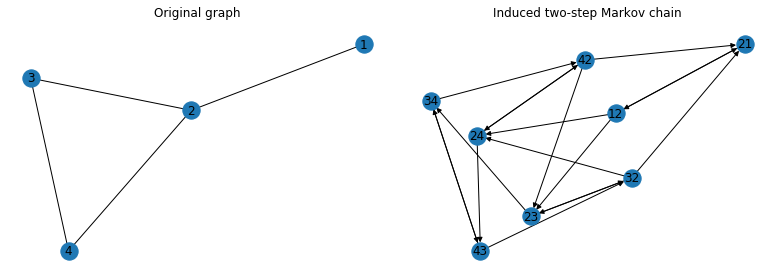

In [2]:
G1, G2 = nx.Graph(), nx.DiGraph()

G1.add_nodes_from([1, 2, 3, 4])

G1.add_edge(1,2)
G1.add_edge(2,3)
G1.add_edge(2,4)
G1.add_edge(3,4)


G2.add_nodes_from([12, 21, 23, 32, 34, 43, 24, 42 ])

G2.add_edge(12, 21)
G2.add_edge(12, 23)
G2.add_edge(12, 24)
G2.add_edge(21, 12)
G2.add_edge(23, 32)
G2.add_edge(23, 34)
G2.add_edge(32, 21)
G2.add_edge(32, 23)
G2.add_edge(32, 24)
G2.add_edge(34, 43)
G2.add_edge(34, 42)
G2.add_edge(43, 32)
G2.add_edge(43, 34)
G2.add_edge(24, 43)
G2.add_edge(24, 42)
G2.add_edge(42, 21)
G2.add_edge(42, 23)
G2.add_edge(42, 24)

fig, axes = plt.subplots(figsize=(11,4), nrows=1, ncols=2)

ax = axes[0]
nx.draw_networkx(G1, ax=ax)
ax.axis('off')
ax.set_title('Original graph')

ax = axes[1]
nx.draw_networkx(G2, ax=ax)
ax.axis('off')
ax.set_title('Induced two-step Markov chain')

plt.tight_layout()
plt.show()

### Numerical solution

In [3]:
def numerical_invariant_distr(P):
    e, U = np.linalg.eig(P.T)
    e = np.real(e)
    U = np.real(U)

    # find index of eigenvalue 1
    idx = np.where(np.abs(e-1)<1e-8)
    u = U[:, idx]
    u /= np.sum(u)
    
    return u.flatten()

### Standard random walk

In [4]:
P_standard = np.array([
    [0, 1, 0, 0], 
    [1/3, 0, 1/3, 1/3],
    [0, 1/2, 0, 1/2],
    [0, 1/2, 1/2, 0],
])

# numerical solution
pi_num = numerical_invariant_distr(P_standard)

# analytic solution
pi_standard = np.array([1, 3, 2, 2])/8

assert np.linalg.norm(pi_num-pi_standard) < 1e-12

### node2vec - breadth-first incentive

In [5]:
p = 0.1
q = 10.0

# normalization constant
a = 1/(1/p+2/q)
b = 1/(1+1/p)
c = 1/(1+1/p+1/q)

P = np.array([
    [0, a/p, a/q, 0, 0, 0, a/q, 0],
    [1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, b/p, b, 0, 0, 0],
    [0, c/q, c/p, 0, 0, 0, c, 0],
    [0, 0, 0, 0, 0, b/p, 0, b],
    [0, 0, 0, b, b/p, 0, 0, 0],
    [0, 0, 0, 0, 0, b, 0, b/p],
    [0, c/q, c, 0, 0, 0, c/p, 0]
])
    
# numerical solution
pi_num = numerical_invariant_distr(P)

# analytical solution
x = ((p+1)*q+p)/(q+2*p)
pi = [1, 1, x, x, x, x, x, x]
pi /= np.sum(pi)

assert np.linalg.norm(pi_num-pi) < 1e-12

# recover the long-term steady state by summing the conditional probabilities
p1 = np.sum(pi[1])
p2 = np.sum(pi[[0, 3, 7]])
p3 = np.sum(pi[[2, 5]])
p4 = np.sum(pi[[4, 6]])

pi_bf = np.array([p1, p2, p3, p4])

### node2vec - depth-first incentive

In [6]:
p = 10.0
q = 0.1

# normalization constant
a = 1/(1/p+2/q)
b = 1/(1+1/p)
c = 1/(1+1/p+1/q)

P = np.array([
    [0, a/p, a/q, 0, 0, 0, a/q, 0],
    [1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, b/p, b, 0, 0, 0],
    [0, c/q, c/p, 0, 0, 0, c, 0],
    [0, 0, 0, 0, 0, b/p, 0, b],
    [0, 0, 0, b, b/p, 0, 0, 0],
    [0, 0, 0, 0, 0, b, 0, b/p],
    [0, c/q, c, 0, 0, 0, c/p, 0]
])
    
# numerical solution
pi_num = numerical_invariant_distr(P)

# analytical solution
x = ((p+1)*q+p)/(q+2*p)
pi = [1, 1, x, x, x, x, x, x]
pi /= np.sum(pi)

assert np.linalg.norm(pi_num-pi) < 1e-12

# recover the long-term steady state by summing the conditional probabilities
p1 = np.sum(pi[1])
p2 = np.sum(pi[[0, 3, 7]])
p3 = np.sum(pi[[2, 5]])
p4 = np.sum(pi[[4, 6]])

pi_df = np.array([p1, p2, p3, p4])

### Compare

Breadth-first sampling gives more weight to clique (2,3,4) while depth-first sampling explores more the isolated node 1.

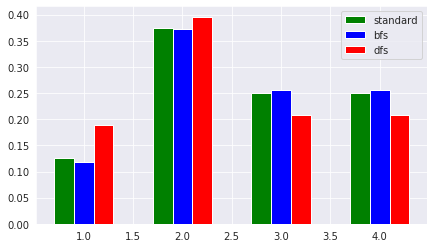

In [7]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(7,4), nrows=1, ncols=1)
    x = np.array([1,2,3,4])
    ax.bar(x-0.2, pi_standard, label='standard', color='g', width=0.2)
    ax.bar(x, pi_bf, label='bfs', color='b', width=0.2)
    ax.bar(x+0.2, pi_df, label='dfs', color='r', width=0.2)
    ax.legend(loc='upper right')